#### Install required libraries


In [1]:
! pip install gpboost==1.2.6
! pip install git+https://github.com/TorkamaniLab/zoish.git
! pip install feature-engine category-encoders scikit-learn ipywidgets numpy pandas --force-reinstall

  Cloning https://github.com/TorkamaniLab/zoish.git to /private/var/folders/v1/xbcjnd1x5rn7ct1m_rnsblk80000gp/T/pip-req-build-32bf__67
  Running command git clone --filter=blob:none --quiet https://github.com/TorkamaniLab/zoish.git /private/var/folders/v1/xbcjnd1x5rn7ct1m_rnsblk80000gp/T/pip-req-build-32bf__67
  Resolved https://github.com/TorkamaniLab/zoish.git to commit 017af4753ddb2d1d4d369f51649d31f96caf6270
  Preparing metadata (setup.py) ... done
  Using cached feature_engine-1.4.0-py2.py3-none-any.whl (276 kB)
  Using cached category_encoders-2.6.3-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached scikit_learn-1.0.2-cp37-cp37m-macosx_10_13_x86_64.whl (7.8 MB)
  Using cached ipywidgets-8.1.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached numpy-1.21.6-cp37-cp37m-macosx_10_9_x86_64.whl (16.9 MB)
  Using cached pandas-1.3.5-cp37-cp37m-macosx_10_9_x86_64.whl (11.0 MB)
  Using cached scipy-1.7.3-cp37-cp37m-macosx_10_9_x86_64.whl (33.0 MB)
  Using cached statsmodels-0.13.5-cp37-

In [2]:
# Importing built-in libraries
import pandas as pd  # For data manipulation and analysis
import sys  # For accessing system-specific parameters and functions
import zoish  # Assuming it's a custom library for your project
import sklearn  # For machine learning models
import numpy  # For numerical computations
import gpboost

# Importing scikit-learn utilities for various ML tasks
from sklearn.compose import ColumnTransformer  # For applying transformers to columns
from sklearn.ensemble import RandomForestClassifier  # Random Forest classifier
from sklearn.impute import SimpleImputer  # For handling missing data
from sklearn.metrics import (  # For evaluating the model
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import GridSearchCV, train_test_split  # For CV and splitting dataset
from sklearn.pipeline import Pipeline  # For creating ML pipelines
from sklearn.preprocessing import StandardScaler  # For feature scaling

# Importing other third-party libraries
from category_encoders import TargetEncoder  # For encoding categorical variables
from zoish.feature_selectors.shap_selectors import (  # For feature selection and visualization
    ShapFeatureSelector,
    ShapPlotFeatures,
)
import logging  # For logging events and errors

# Configuring logging settings
from zoish import logger  # Assuming it's a custom logger from zoish
logger.setLevel(logging.ERROR)  # Set logging level to ERROR

# Importing feature imputation library
from feature_engine.imputation import MeanMedianImputer  # For imputing mean/median

# Re-setting logging level (this seems redundant, consider keeping only one)
logger.setLevel(logging.ERROR)

# Printing versions of key libraries for debugging and documentation
print(f'Python version : {sys.version}')
print(f'zoish version : {zoish.__version__}')
print(f'sklearn version : {sklearn.__version__}')
print(f'pandas version : {pd.__version__}')  # Using the alias for pandas
print(f'numpy version : {numpy.__version__}')
print(f'gpboost version : {gpboost.__version__}')


Python version : 3.7.8 (default, Feb 27 2023, 18:11:31) 
[Clang 14.0.0 (clang-1400.0.29.202)]
zoish version : 5.0.3
sklearn version : 1.0.2
pandas version : 1.3.5
numpy version : 1.21.6
gpboost version : 1.2.6


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Example: Audiology (Standardized) Data Set
###### https://archive.ics.uci.edu/ml/datasets/Audiology+%28Standardized%29


#### Read data


In [3]:
import gpboost as gpb
import numpy as np
from sklearn.datasets import make_classification
# Generate classification data for mixed effect model
X, y = make_classification(n_samples=1000, n_features=100, n_informative=50, n_redundant=0, random_state=42)
X = pd.DataFrame(X)

# Generate random effects
n_groups = 5 # Reduced number of groups for simplicity
groups = np.random.choice(n_groups, size=X.shape[0])

# Define fixed group effects
group_effects = np.random.normal(0, 1, n_groups)  # Random effects for each group
random_effects = group_effects[groups]

# Adjust y based on random effects
y = np.where(y + random_effects > 0, 1, 0)

#### Defining the feature pipeline steps:
Here, we use an untuned gpb.GPBoostClassifier model with the ShapFeatureSelector.In the next section, we will repeat the same process but with a tuned gpb.GPBoostClassifier. The aim is to demonstrate that a better estimator can yield improved results when used with the ShapFeatureSelector.


In [4]:
from sklearn.model_selection import KFold


X_train, X_test, y_train, y_test,groups_train,groups_test = train_test_split(
    X, y, groups, test_size=0.33,  random_state=42
)

gp_model_train = gpb.GPModel(group_data=groups_train, likelihood="gaussian")
gp_model_train.set_prediction_data(group_data_pred=groups_train)

bst = gpb.GPBoostClassifier(
    boosting_type='gbdt',
    objective='binary',  # 'binary' is for binary classification
    n_estimators=100,  # Equivalent to num_boost_round in gpboost.train
)

# Fit the model
bst.fit(X_train, y_train,gp_model=gp_model_train)
shap_feature_selector = ShapFeatureSelector(
        bst,
        n_iter=10,
        scoring="f1",
        direction="maximum",
        cv=KFold(n_splits=2, shuffle=True),
        # for gpboost this should be False
        use_faster_algorithm=False,
        num_features=50,
        shap_fast_tree_explainer_kwargs={'algorithm':'v2'},
        # pred_contrib = True  is important for feature selection by shap
        predict_params={'group_data_pred':groups_train,'fixed_effects_pred':None,'pred_contrib':True},
)

        
# Define pre-processing for numeric columns (float and integer types)
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Define pre-processing for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', TargetEncoder(handle_missing='return_nan'))])

# Combine preprocessing into one column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature Selection using ShapSelector 
feature_selection = shap_feature_selector 


# Create a pipeline that combines the preprocessor with a feature selection and a classifier
transformers = Pipeline(steps=[('preprocessor', preprocessor),
                           ('feature_selection', feature_selection),
                           #('classifier', classifier)
                           ]
                           
                           )

# Fit the model
XT_train=transformers.fit_transform(X_train, y_train)
XT_test=transformers.transform(X_test)


# Fit the model
bst.fit(XT_train, y_train,gp_model=gp_model_train)

# Predict on test data
y_test_pred = bst.predict(X=XT_test, group_data_pred=groups_test)

# Output first 10 predictions
print(y_test_pred[0:10])



[1 1 1 1 1 1 1 1 1 1]


#### Check performance of the Pipeline


In [5]:

print("F1 score : ")
print(f1_score(y_test, y_test_pred,average='micro'))
print("Classification report : ")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix : ")
print(confusion_matrix(y_test, y_test_pred))



F1 score : 
1.0
Classification report : 
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       330

    accuracy                           1.00       330
   macro avg       1.00      1.00      1.00       330
weighted avg       1.00      1.00      1.00       330

Confusion matrix : 
[[330]]


#### Shap related plots

feature_selector.importance_df.shape[0] 100
feature_selector.num_features 50


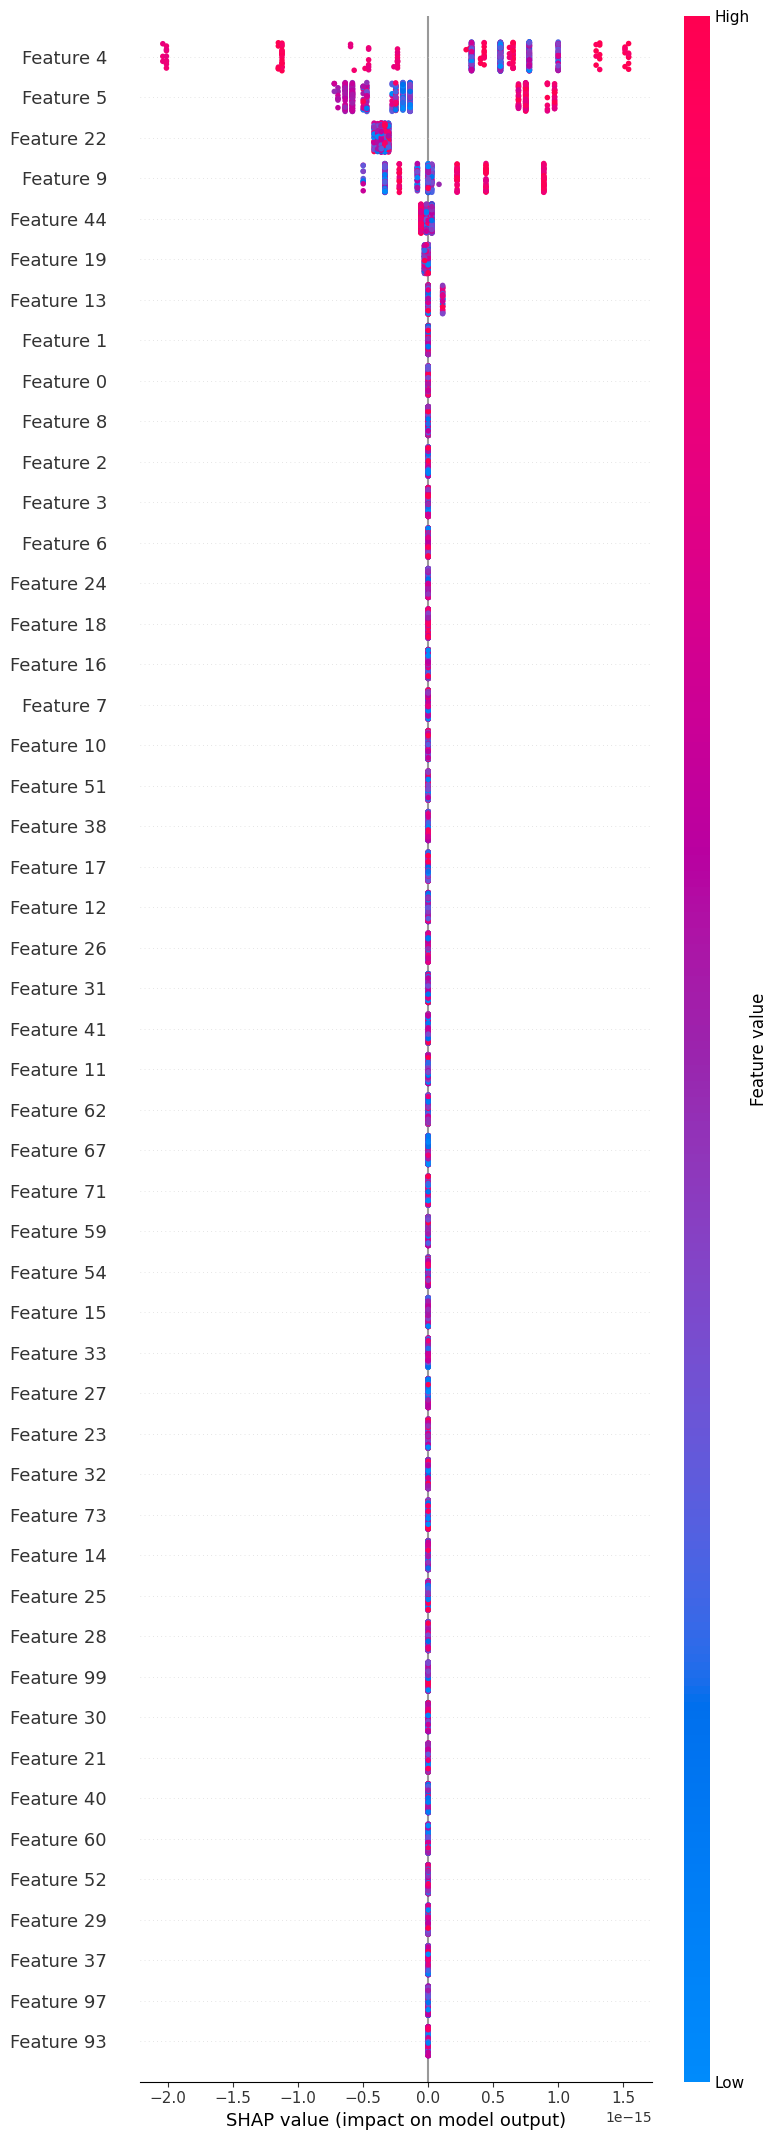

In [6]:

# Plot the feature importance
plot_factory = ShapPlotFeatures(shap_feature_selector) 
plot_factory.summary_plot()


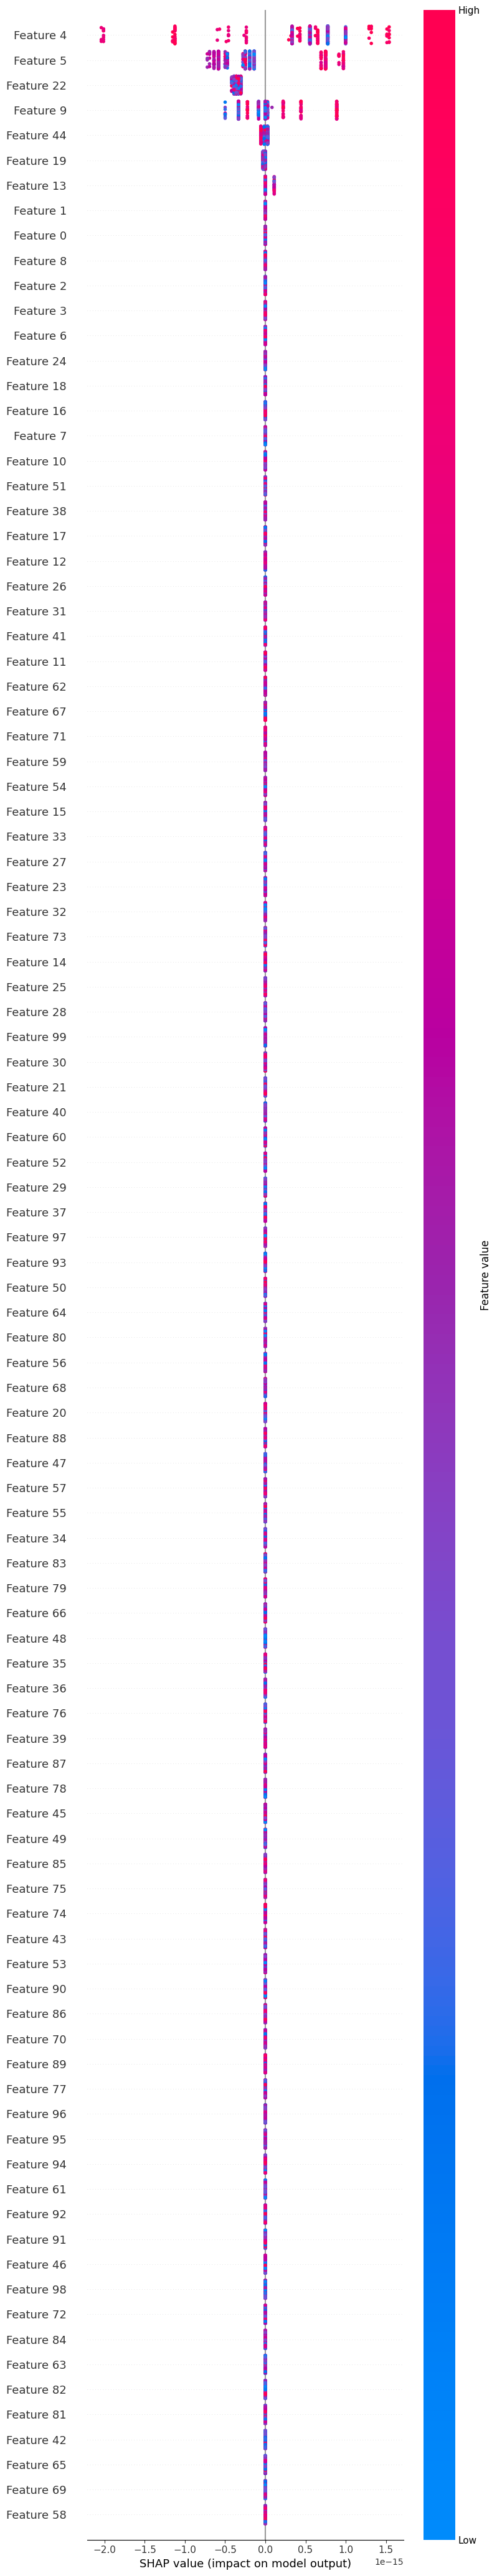

In [7]:
plot_factory.summary_plot_full()

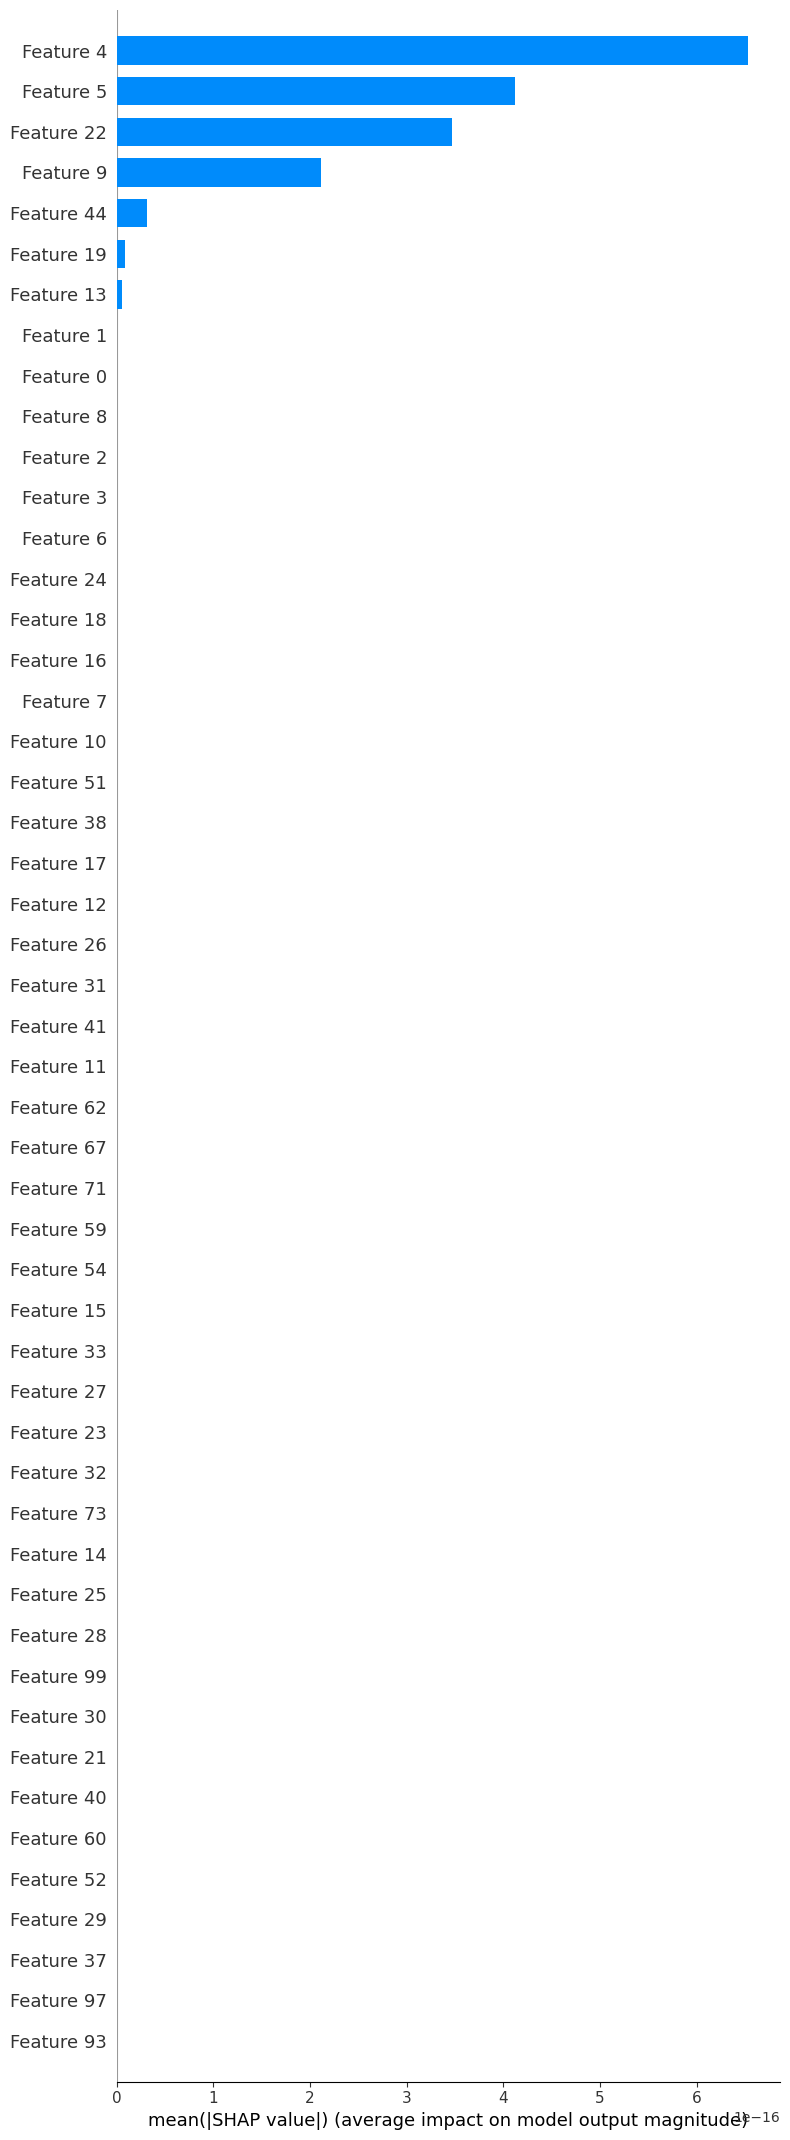

In [8]:

# Plot the feature importance
plot_factory.bar_plot()

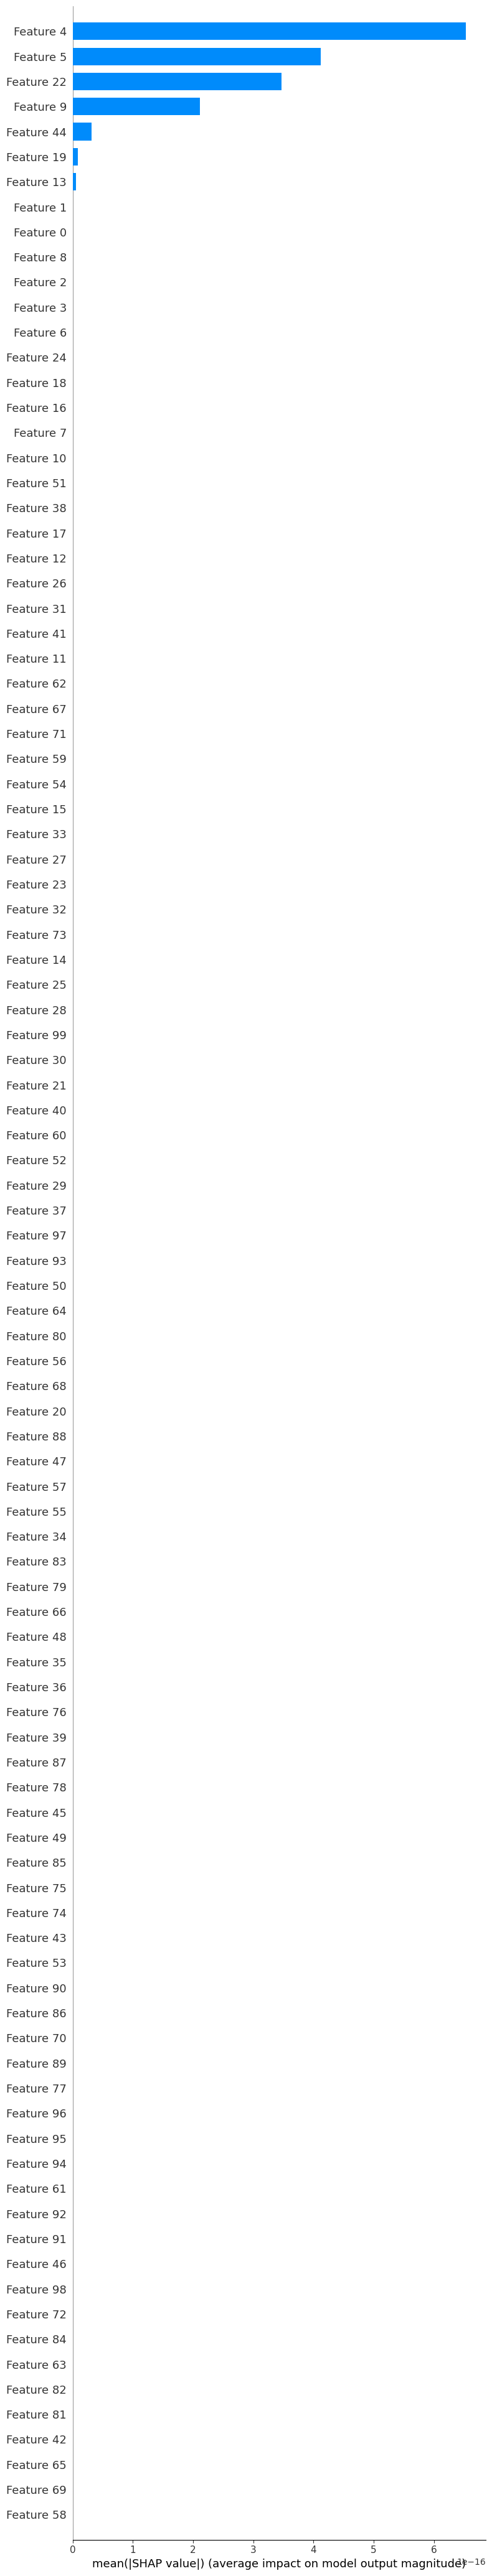

In [9]:
plot_factory.bar_plot_full()